# Ex7 인물사진을 만들어보자 

###  목표 
1. 인물사진, 고양이사진에 대한 아웃포커싱 효과 적용하기
2. 인물사진에서 발생한 문제점 표시하기
3. 배경전환 크로마키 사진 만들기
4. semantic segmentation mask의 오류를 보완할 수 있는 솔루션 제안.

##  인물사진 고양이사진 아웃포커싱 적용

* 아웃포커싱할 이미지를 업로드하여 가져왔습니다. 인물사진: 아이유사진 2장, 고양이사진, 배경사진을 업로드 했습니다.

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib
from matplotlib import pyplot as plt
import tensorflow as tf
from PIL import ImageFont, Image, ImageDraw

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/IU8.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_path2= os.getenv('HOME')+'/aiffel/human_segmentation/images/IU7.jpg'
img_path3= os.getenv('HOME')+'/aiffel/human_segmentation/images/cat2.jpg'
img_orig = cv2.imread(img_path)
img_orig2 = cv2.imread(img_path2)
img_orig3 = cv2.imread(img_path3)
img_path4= os.getenv('HOME')+'/aiffel/human_segmentation/images/blo.jpeg'
img_orig4 = cv2.imread(img_path4)

print (img_orig.shape)
print (img_orig2.shape)
print (img_orig3.shape)
back=cv2.resize(img_orig4,dsize=(1080,1080))
print (back.shape)

(478, 480, 3)
(1080, 1080, 3)
(360, 640, 3)
(1080, 1080, 3)


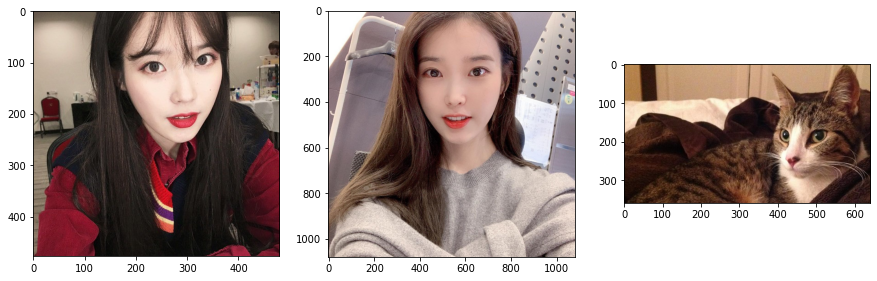

In [3]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))


* DeepLab 모델을 정의했습니다.

In [4]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [5]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [6]:
img_resized, seg_map = MODEL.run(img_orig)
img_resized2, seg_map2 = MODEL.run(img_orig2)
img_resized3, seg_map3 = MODEL.run(img_orig3)

print (img_orig.shape, img_resized.shape, seg_map.max())
print (img_orig2.shape, img_resized2.shape, seg_map2.max())
print (img_orig3.shape, img_resized3.shape, seg_map3.max())


(478, 480, 3) (510, 513, 3) 15
(1080, 1080, 3) (513, 513, 3) 15
(360, 640, 3) (288, 513, 3) 8


* 세그멘테이션을 진행했습니다.

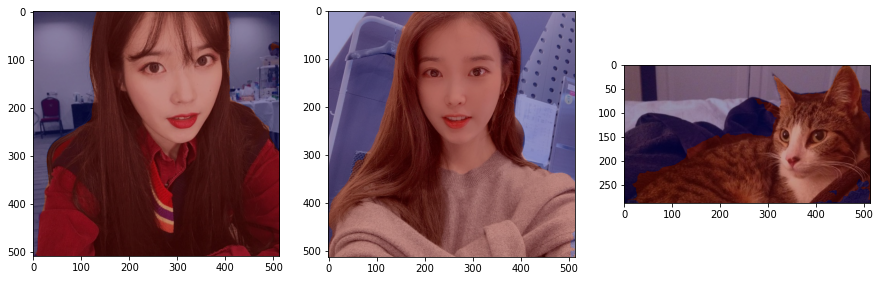

In [7]:
plt.figure(figsize=(15,6))
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))


img_show2 = img_resized2.copy()
seg_map2 = np.where(seg_map2 == 15, 15, 0) # 예측 중 사람만 추출
img_mask2 = seg_map2 * (255/seg_map2.max()) # 255 normalization
img_mask2 = img_mask2.astype(np.uint8)
color_mask2 = cv2.applyColorMap(img_mask2, cv2.COLORMAP_JET)
img_show2 = cv2.addWeighted(img_show2, 0.6, color_mask2, 0.35, 0.0)
plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB))

img_show3 = img_resized3.copy()
seg_map3 = np.where(seg_map3 == 8, 8, 0) # 예측 중 사람만 추출
img_mask3 = seg_map3 * (255/seg_map3.max()) # 255 normalization
img_mask3 = img_mask3.astype(np.uint8)
color_mask3 = cv2.applyColorMap(img_mask3, cv2.COLORMAP_JET)
img_show3 = cv2.addWeighted(img_show3, 0.6, color_mask3, 0.35, 0.0)
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(img_show3, cv2.COLOR_BGR2RGB))




plt.show()

* resize 복원 및 mask 사진을 출력해봤습니다.

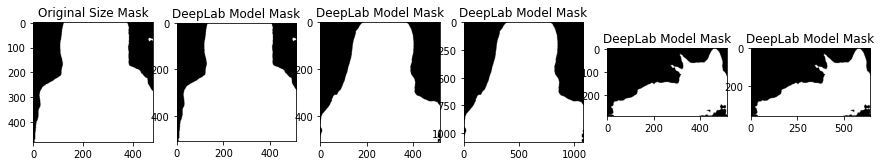

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

img_mask_up2 = cv2.resize(img_mask2, img_orig2.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up2 = cv2.threshold(img_mask_up2, 128, 255, cv2.THRESH_BINARY)

img_mask_up3 = cv2.resize(img_mask3, img_orig3.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up3 = cv2.threshold(img_mask_up3, 128, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(15,6))

ax = plt.subplot(1,6,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,6,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')


ax = plt.subplot(1,6,3)
plt.imshow(img_mask2, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

ax = plt.subplot(1,6,4)
plt.imshow(img_mask_up2, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')


ax = plt.subplot(1,6,5)
plt.imshow(img_mask3, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

ax = plt.subplot(1,6,6)
plt.imshow(img_mask_up3, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')



plt.show()


* blur 처리를 하고 출력했습니다.

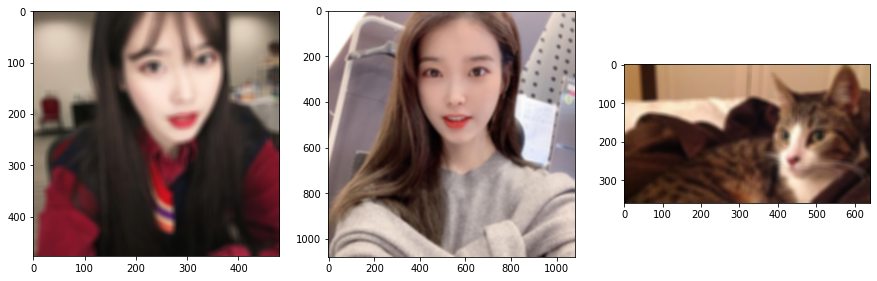

In [9]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
img_orig_blur2 = cv2.blur(img_orig2, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
img_orig_blur3 = cv2.blur(img_orig3, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(img_orig_blur2, cv2.COLOR_BGR2RGB))
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(img_orig_blur3, cv2.COLOR_BGR2RGB))
plt.show()

* blur된 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출했습니다.

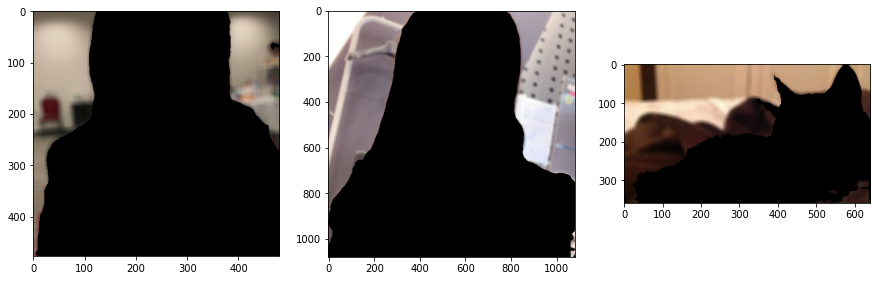

In [10]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

img_mask_color2 = cv2.cvtColor(img_mask_up2, cv2.COLOR_GRAY2BGR)
img_bg_mask2 = cv2.bitwise_not(img_mask_color2)
img_bg_blur2 = cv2.bitwise_and(img_orig_blur2, img_bg_mask2)


img_mask_color3 = cv2.cvtColor(img_mask_up3, cv2.COLOR_GRAY2BGR)
img_bg_mask3 = cv2.bitwise_not(img_mask_color3)
img_bg_blur3 = cv2.bitwise_and(img_orig_blur3, img_bg_mask3)
#img_bg_blur3 = cv2.bitwise_and(img_orig4, img_bg_mask3)
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))


plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(img_bg_blur2, cv2.COLOR_BGR2RGB))

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(img_bg_blur3, cv2.COLOR_BGR2RGB))

plt.show()


* 세그멘테이션이 잘못된 부분을 화살표로 표시를 했습니다. 

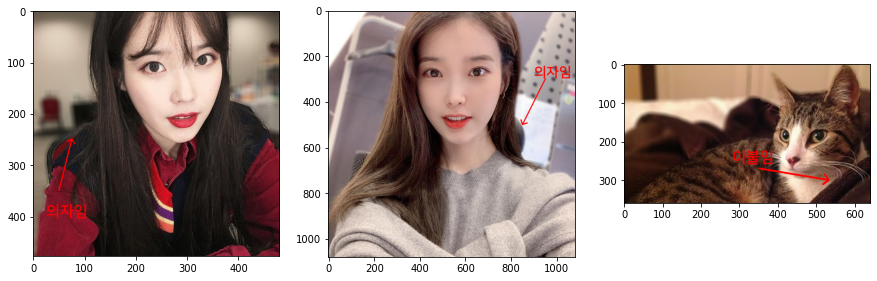

In [11]:
plt.figure(figsize=(15,6))
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
cv2.arrowedLine(img_concat,(50,350),(75,250),(0,0,255),2)
img_pil=Image.fromarray(img_concat)
draw=ImageDraw.Draw(img_pil)
draw.text((25,375),"의자임",font=ImageFont.truetype("NanumSquareB.ttf",30),fill=(0,0,255))
img_concat=np.array(img_pil)
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))


img_concat2 = np.where(img_mask_color2==255, img_orig2, img_bg_blur2)
cv2.arrowedLine(img_concat2,(950,300),(850,500),(0,0,255),4)
img_pil2=Image.fromarray(img_concat2)
draw2=ImageDraw.Draw(img_pil2)
draw2.text((900,240),"의자임",font=ImageFont.truetype("NanumSquareB.ttf",60),fill=(0,0,255))
img_concat2=np.array(img_pil2)
plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))


img_concat3 = np.where(img_mask_color3==255, img_orig3, img_bg_blur3)

cv2.arrowedLine(img_concat3,(350,270),(530,300),(0,0,255),4)
img_pil3=Image.fromarray(img_concat3)
draw3=ImageDraw.Draw(img_pil3)
draw3.text((280,220),"이불임",font=ImageFont.truetype("NanumSquareB.ttf",40),fill=(0,0,255))
img_concat3=np.array(img_pil3)

#img_orig5=cv2.copyTo(img_orig3, img_mask_up3, back)

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))
plt.show()

* 아이유 사진에대해 배경화면을 변경해봤습니다.

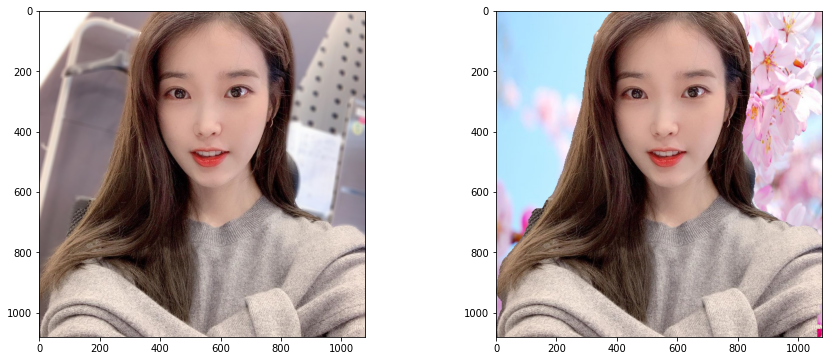

In [12]:
plt.figure(figsize=(15,6))
img_concat2 = np.where(img_mask_color2==255, img_orig2, img_bg_blur2)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))

img_orig5=cv2.copyTo(img_orig2, img_mask_up2, back)
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_orig5, cv2.COLOR_BGR2RGB))
plt.show()

# 인물모드 사진의 문제점 분석하기

## 1. Deeplab을 활용한 2D RGB 이미지 세그멘테이션의 한계점 분석

### -결과의 문제점 인식
* 위의 결과를 보면 인물사진과 고양이 사진에 대해 Deeplab 모델을 활용하여 semantic segmentation을 하여 아웃포커싱 효과를 넣어봤습니다. 그 결과 사람과 고양이는 잘인식이 되었습니다. 그러나 인물사진과 고양이 사진 모두 그 근처에있는 물체를 mask를 하지 못했습니다. 인물사진은 의자에 앉아있는 사진인데 의자를 mask하지 못했고 고양이 사진은 근처 담뇨를 mask 하지 못했습니다.

### -문제의 원인 분석
* 위의 결과를 보면 세밀하지 못한 분할이 이루어진 것을 볼 수 있습니다. 이러한 문제의 원인은 여러가지 생각해 볼 수 있습니다. 
1. Deeplab 모델의 적용 방식을 보면 원본 이미지를 모델의  인풋에 맞도록 작게 resize한 후 모델에 적용시키고 원래 크기로 늘리는 과정에서의 이미지 손실로인해 발생한 문제 일 수 있습니다. 
2. 2D RGB 이미지를 활용한 세그멘테이션은 평면 이미지의 색만 보기 때문에 비슷한 색깔이 있거나 할 경우 정확한 윤곽선을 찾기 힘들다는 점이 있습니다. 


### - 문제 해결 방안 제안
*  LMS 내용을 보면 이미지의 깊이(Depth)를 활용하여 해당 문제를 해결하는 방안을 제안하라고 말씀하셨습니다. 이 개념을 참고한 제가 제안한 방법은 다음과 같습니다. 이미지의 깊이는 카메라와 물체사이의 거리를 의미합니다. 이미지에서 깊이를 안다면 그 물체의 구조를 파악할 수 있습니다[1]. 이러한 구조 정보를 활용하여 [2]의 모델을 활용해 학습하면 상대적으로 정확한 윤곽선을 파악할 수 있다고 합니다. 따라서 Deeplab 모델을 활용하여 RGB 이미지를 세그멘테이션을 하여 레이블 맵을 만들고, 원본 이미지의 Depth를 활용하여 윤과선 추출 모델을 적용하여 윤곽선 맵을 만든 다음 두 맵을 비교하여 레이블된 물체가 정확한 윤곽선을 갖도록 새롭게 레이블링을 하여 이미지를 보정하는 방식으로 해결할 수 있을 것이라 생각됩니다. 이를 설명하는 순서도는 아래와 같습니다.  

<img src="image1.png">
<br><br> 

## Reference
[1] Gupta, S., Arbel´aez, P., Malik, J.: Perceptual organization and recognition of indoor scenes from RGB-D images. In: CVPR (2013)

[2] Doll´ar, P., Zitnick, C.L.: Structured forests for fast edge detection. In: ICCV (2013)